In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.sequence import pad_sequences

In [10]:
df = pd.read_csv('pro_news_classifier.csv')

In [14]:
df.head()

,title,class
0,Trump Loses His Sh*t After Nordstrom Stops Pe...,0
1,South Korea's Moon says North Korea missile ca...,1
2,"Hezbollah declares Syria victory, Russia says ...",1
3,Two Palestinians killed in anti-US protests af...,1
4,HUCKABEE : ‘Hillary Is In for the Ride of Her ...,0


In [13]:
df = df.drop(['Unnamed: 0'], axis=1)

In [15]:
df.isnull().sum()

title    0
class    0
dtype: int64

In [16]:
df.dtypes

title    object
class     int64
dtype: object

In [19]:
import preprocess_kgptalkie as ps
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [20]:
df['title']=df['title'].apply(lambda x: get_clean(x))

In [21]:
tokenizer = Tokenizer(num_words=5000, split=" ")

In [22]:
tokenizer.fit_on_texts(df['title'].values)

In [23]:
X = tokenizer.texts_to_sequences(df['title'].values)

In [24]:
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    2,  798,   27,
         878,   15, 4402, 2467, 4837,  715],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  134,
         966, 2468,   13,   49,   64,  487],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 2059, 1167,  126,  675,   43,
          13,  618,    5,  464, 1187,   95],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  

In [37]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 39, 256)           1280000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 39, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 39, 256)           525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [41]:
y = pd.get_dummies(df['class']).values

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [44]:
batch_size = 64
epochs = 5

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test,y_test))

Epoch 1/5
562/562 [==============================] - 227s 405ms/step - loss: 0.1510 - accuracy: 0.9415 - val_loss: 0.1092 - val_accuracy: 0.9573
Epoch 2/5
562/562 [==============================] - 221s 393ms/step - loss: 0.0836 - accuracy: 0.9700 - val_loss: 0.1067 - val_accuracy: 0.9608
Epoch 3/5
562/562 [==============================] - 245s 436ms/step - loss: 0.0633 - accuracy: 0.9770 - val_loss: 0.1221 - val_accuracy: 0.9611
Epoch 4/5
562/562 [==============================] - 238s 424ms/step - loss: 0.0460 - accuracy: 0.9834 - val_loss: 0.1271 - val_accuracy: 0.9602
Epoch 5/5
562/562 [==============================] - 238s 423ms/step - loss: 0.0360 - accuracy: 0.9869 - val_loss: 0.1421 - val_accuracy: 0.9618


In [45]:
import matplotlib.pyplot as plt 

def plot_graph(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' +metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.15671531837433578)

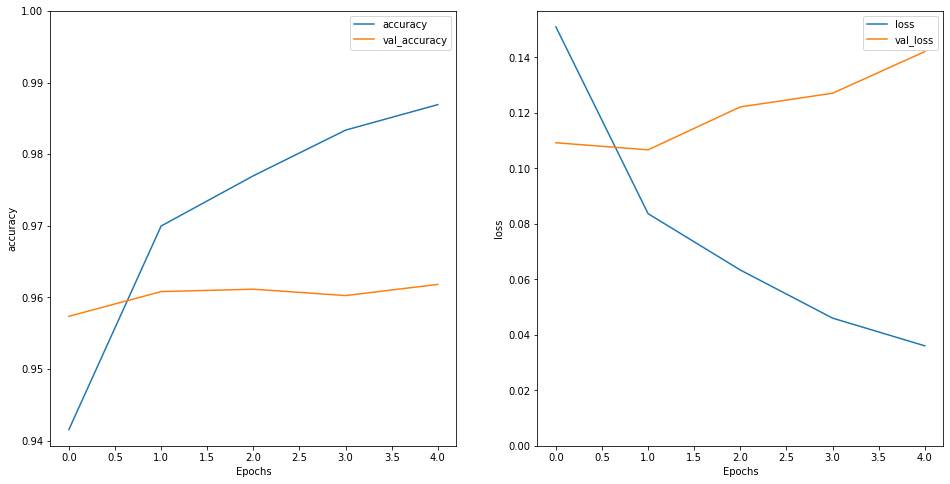

In [46]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graph(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graph(history, 'loss')
plt.ylim(0, None)